In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings

CSV_PATH      = "amazon-cleaned.csv"  # adjust if the file lives elsewhere
NUMERIC_COLS  = [
    "category", "discounted_price", "actual_price",
    "rating", "rating_count", "encode_review_rating"
]
MIN_SAMPLES   = 5          # DBSCAN min_pts (k in k-distance)
SAMPLE_LIMIT  = 3000       # set None to run on full data (may be heavy)


## 2. Load & scale

In [47]:

df = pd.read_csv("preprocess/amazon-cleaned.csv")
X   = df[NUMERIC_COLS].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional random down-sample (for big datasets / memory limits)
if SAMPLE_LIMIT and X_scaled.shape[0] > SAMPLE_LIMIT:
    rng = np.random.default_rng(42)
    idx = rng.choice(X_scaled.shape[0], size=SAMPLE_LIMIT, replace=False)
    X_scaled_run = X_scaled[idx]
    print(f"Running on a random subset of {SAMPLE_LIMIT:,} rows "
          f"(out of {X_scaled.shape[0]:,})")
else:
    X_scaled_run = X_scaled
    print(f"Running on the full dataset – {X_scaled.shape[0]:,} rows")

Running on a random subset of 3,000 rows (out of 11,444)


## 3. k-distance plot (choose ε visually)

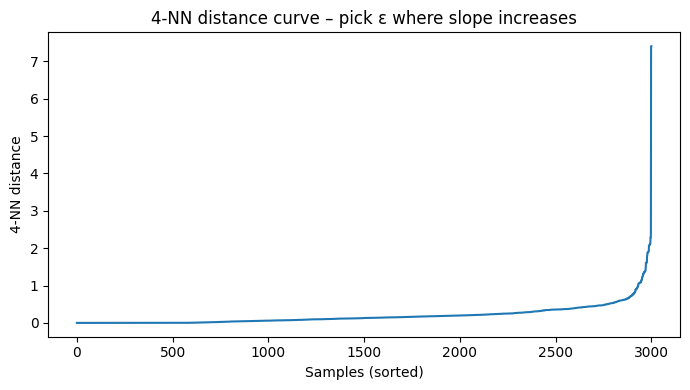

Chosen eps ≈ 0.6554  (95th percentile of 4-NN distances)


In [48]:

k = MIN_SAMPLES
nn = NearestNeighbors(n_neighbors=k).fit(X_scaled_run)
dists, _ = nn.kneighbors(X_scaled_run)
k_dist = np.sort(dists[:, k - 1])

plt.figure(figsize=(7, 4))
plt.plot(k_dist)
plt.title(f"{k-1}-NN distance curve – pick ε where slope increases")
plt.xlabel("Samples (sorted)")
plt.ylabel(f"{k-1}-NN distance")
plt.tight_layout()
plt.show()

# Heuristic: ε = 95th percentile of non-zero k-distances
eps = np.percentile(k_dist[k_dist > 0], 95)
print(f"Chosen eps ≈ {eps:.4f}  (95th percentile of {k-1}-NN distances)")


## 4. Run DBSCAN

In [49]:

db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES)
labels = db.fit_predict(X_scaled_run)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = int((labels == -1).sum())
print(f"→ DBSCAN found {n_clusters} clusters")
print(f"→ Noise points: {n_noise}  ({n_noise / len(labels):.1%})")



→ DBSCAN found 19 clusters
→ Noise points: 109  (3.6%)


## 5. Cluster quality (silhouette without noise)

In [50]:
mask = labels != -1
if n_clusters > 1 and mask.sum() > n_clusters:
    sil = silhouette_score(X_scaled_run[mask], labels[mask])
    print(f"Silhouette (noise excluded): {sil:.3f}")

Silhouette (noise excluded): 0.195


## 6. Cluster size table

In [51]:

cluster_sizes = (
    pd.Series(labels)
      .value_counts()
      .sort_index()
      .rename_axis("cluster")
      .to_frame("count")
)
print("\nCluster size breakdown:")
print(cluster_sizes)


Cluster size breakdown:
         count
cluster       
-1         109
 0        2064
 1           5
 2         647
 3           9
 4          25
 5           6
 6           5
 7           9
 8           9
 9           9
 10         36
 11         20
 12          9
 13          7
 14          6
 15          5
 16         10
 17          5
 18          5


## 7. Visualise in 2-D via PCA

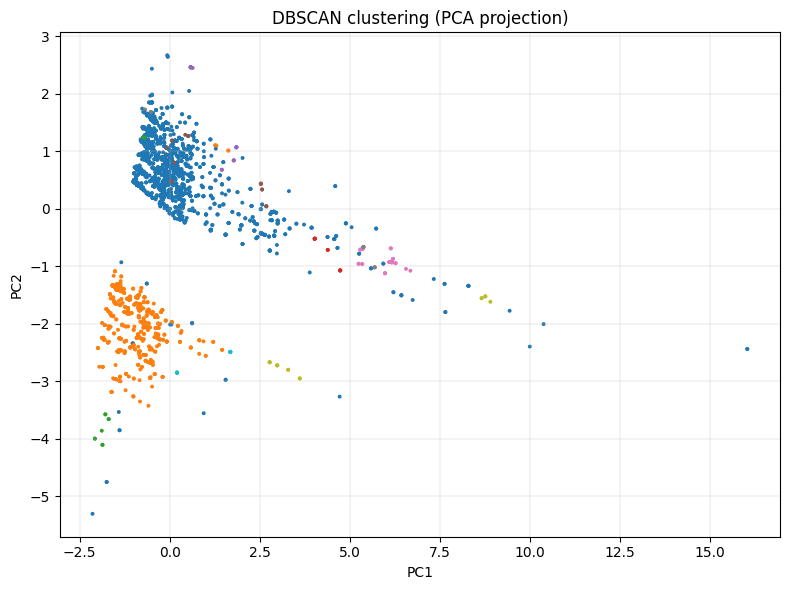

In [ ]:

coords = PCA(n_components=2, random_state=0).fit_transform(X_scaled_run)
plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1],
            s=8, c=labels, cmap="tab10", linewidth=0)
plt.title("DBSCAN clustering  (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, linewidth=0.2); plt.tight_layout()
plt.show()

## 8. (Optional) Save labelled sample to CSV

In [53]:

out = pd.DataFrame(X_scaled_run, columns=[f"z_{c}" for c in NUMERIC_COLS])
out["dbscan_label"] = labels
out.to_csv("preprocess/amazon_dbscan_sample_labelled.csv", index=False)
print("\nLabelled sample saved to preprocess/amazon_dbscan_sample_labelled.csv")



Labelled sample saved to preprocess/amazon_dbscan_sample_labelled.csv
